In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt

In [2]:
df_test = pd.read_csv("/Users/eva/Documents/Study/Y1S2/DMT/assignment2/best_feature_engineered_test_set_VU_DM.csv")


In [ ]:
print(df_test.shape)

In [3]:
base_path = '/Users/eva/Documents/Study/Y1S2/DMT/assignment2/'
file_pattern = 'best_feature_engineered_training_chunk_{}.csv'
for i in range(10):
    df_chunk = pd.read_csv(base_path + file_pattern.format(i))
    if i == 0:
        df = df_chunk
    else:
        df = pd.concat([df, df_chunk], axis=0)
df.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,price_location_ratio,price_per_adult,price_per_person,prop_historical_price,prop_clicked_prob,child_bool,price_review_ratio,price_starrating_ratio,price_rank_percentile,location1_rank_percentile
0,1,2013-04-04 08:32:15,12,187,0.0,0.0,219,893,3,3.5,...,37.021201,26.1925,26.1925,141.174964,0.0,False,29.934286,34.923333,0.429825,0.780702
1,1,2013-04-04 08:32:15,12,187,0.0,0.0,219,10404,4,4.0,...,77.609091,42.6850,42.6850,152.933013,0.0,False,42.685000,42.685000,0.842105,0.228070
2,1,2013-04-04 08:32:15,12,187,0.0,0.0,219,21315,3,4.5,...,81.727273,44.9500,44.9500,137.002613,0.0,False,39.955556,59.933333,0.859649,0.228070
3,1,2013-04-04 08:32:15,12,187,0.0,0.0,219,27348,2,4.0,...,171.321555,121.2100,121.2100,80.640419,0.0,False,121.210000,242.420000,1.000000,0.780702
4,1,2013-04-04 08:32:15,12,187,0.0,0.0,219,29604,4,3.5,...,54.386364,35.8950,35.8950,138.379512,0.0,False,41.022857,35.895000,0.719298,0.517544


In [4]:
original_train_len = len(df)
original_test_len = len(df_test)

In [5]:
combined_df = pd.concat([df, df_test], ignore_index=False)

user_price_stats = combined_df.groupby('visitor_hist_adr_usd')['price_usd'].mean().reset_index()
user_price_stats.columns = ['visitor_hist_adr_usd', 'mean_user_booking_price']
combined_df = combined_df.merge(user_price_stats, on='visitor_hist_adr_usd', how='left')


In [ ]:
combined_df.head()

In [6]:
price_stats = combined_df.groupby('srch_destination_id')['price_usd'].agg(['mean', 'std']).reset_index()
price_stats.columns = ['srch_destination_id', 'mean_price_destination', 'std_price_destination']
combined_df = combined_df.merge(price_stats, on='srch_destination_id', how='left')


In [7]:
# drop price_per_person_rank_percentile
combined_df = combined_df.drop(columns=['price_per_person_rank_percentile'])

In [8]:
competitor_cols = ['comp1_rate', 'comp2_rate']
combined_df['total_competitors'] = combined_df[competitor_cols].notnull().sum(axis=1)
combined_df['total_promotions'] = combined_df[competitor_cols].applymap(lambda x: 1 if x == 1 else 0).sum(axis=1)


/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_73153/2109357868.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  combined_df['total_promotions'] = combined_df[competitor_cols].applymap(lambda x: 1 if x == 1 else 0).sum(axis=1)


In [9]:
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd

# 假设 combined_df 是你已经加载的主要数据框
features_to_poly = [
    'prop_starrating', 
    'prop_review_score', 'prop_location_score1', 'prop_location_score2', 
    'prop_log_historical_price', 'price_usd'
]

# 过滤数据框，只包含选定的特征
X = combined_df[features_to_poly]

# 生成多项式特征
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# 获取多项式特征的名称，并添加后缀
poly_columns = poly.get_feature_names_out(input_features=features_to_poly)
poly_columns = [col + '_poly' for col in poly_columns]

# 创建多项式特征的数据框
X_poly_df = pd.DataFrame(X_poly, columns=poly_columns)

# 确保索引唯一
assert combined_df.index.is_unique, "Index in combined_df is not unique"
assert X_poly_df.index.is_unique, "Index in X_poly_df is not unique"

combined_df.reset_index(drop=True, inplace=True)
X_poly_df.reset_index(drop=True, inplace=True)

# 合并原始数据框和多项式特征数据框
combined_df = pd.concat([combined_df, X_poly_df], axis=1)

# 打印结果以确认
print(combined_df.head())


   srch_id            date_time  site_id  visitor_location_country_id  \
0        1  2013-04-04 08:32:15       12                          187   
1        1  2013-04-04 08:32:15       12                          187   
2        1  2013-04-04 08:32:15       12                          187   
3        1  2013-04-04 08:32:15       12                          187   
4        1  2013-04-04 08:32:15       12                          187   

   visitor_hist_starrating  visitor_hist_adr_usd  prop_country_id  prop_id  \
0                      0.0                   0.0              219      893   
1                      0.0                   0.0              219    10404   
2                      0.0                   0.0              219    21315   
3                      0.0                   0.0              219    27348   
4                      0.0                   0.0              219    29604   

   prop_starrating  prop_review_score  ...  prop_location_score1^2_poly  \
0                

In [10]:
df = combined_df.iloc[:original_train_len]
df_test = combined_df.iloc[original_train_len:original_train_len + original_test_len]

In [11]:
# print columns with NA in df
print(df.columns[df.isnull().any()].tolist())

['hist_price_interaction']


In [12]:
# print columns with NA in df_test
print(df_test.columns[df_test.isnull().any()].tolist())

['position', 'click_bool', 'gross_bookings_usd', 'booking_bool', 'hist_price_interaction']


In [13]:
# drop ['position', 'gross_bookings_usd'] in df_test
df_test = df_test.drop(columns=['position', 'gross_bookings_usd', 'click_bool', 'booking_bool'])

In [ ]:
print(df_test.columns[df_test.isnull().any()].tolist())
print(df.columns[df.isnull().any()].tolist())

In [14]:
columns = df.columns

features = [
    col for col in columns if col not in ['date_time', 'position', 'click_bool', 'booking_bool', 'score', 'srch_id']
    and 'gross_bookings_usd' not in col and 'position' not in col and col != 'price_per_person_rank_percentile'
]


print(len(features))
print(len(df.columns))

101
107


In [ ]:
print(features)

In [ ]:
df_test.to_csv('/Users/eva/Documents/Study/Y1S2/DMT/assignment2/bookingbool_feature_engineered_test_set_VU_DM.csv', index=False)

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
import random

In [15]:
def assign_scores(row):
    if row['booking_bool'] == 1:
        return 5
    elif row['click_bool'] == 1:
        return 1
    else:
        return 0

In [16]:
df['score'] = df.apply(assign_scores, axis=1)

/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_73153/1548486905.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = df.apply(assign_scores, axis=1)


In [19]:
unique_ids = df['srch_id'].unique()
train_ids, test_ids = train_test_split(unique_ids, test_size=0.25, random_state=42, shuffle=True)  # 首先分割出20%为最终测试集
train_val_ids, val_ids = train_test_split(train_ids, test_size=0.25, random_state=42, shuffle=True)  # 将剩余80%分为训练集(60%)和验证集(20%)

train_df = df[df['srch_id'].isin(train_val_ids)]
val_df = df[df['srch_id'].isin(val_ids)]
test_df = df[df['srch_id'].isin(test_ids)]

train_data = lgb.Dataset(train_df[features], label=train_df['score'], group=train_df['srch_id'].value_counts().sort_index())
val_data = lgb.Dataset(val_df[features], label=val_df['score'], group=val_df['srch_id'].value_counts().sort_index())
test_data = lgb.Dataset(test_df[features], label=test_df['score'], group=test_df['srch_id'].value_counts().sort_index())

In [21]:
param_grid = {
    'num_leaves': [130, 120], 'max_depth': [13], 'min_child_samples': [210,220], 'learning_rate': [0.1], 'feature_fraction': [0.85,0.8], 
    'bagging_fraction': [0.9], 'bagging_freq': [2,3], 'reg_alpha': [20,25], 'reg_lambda': [100], 'num_iterations': [300] 
}

# random search
best_ndcg = 0
best_params = None
n_iterations = 50  # iterations for random search
tested_params = set()

for _ in range(n_iterations):
    # Generate unique random parameter combination
    random_params = {k: random.choice(v) for k, v in param_grid.items()}
    param_tuple = tuple(random_params.items())  # Convert to tuple to be hashable
    if param_tuple in tested_params:
        continue  # Skip this iteration if we've already tested these parameters
    tested_params.add(param_tuple)  # Add new parameters to the set

    # Additional parameters
    random_params.update({
        'objective': 'lambdarank',
        'metric': 'ndcg',
        'ndcg_eval_at': [5],
        'verbose': -1,
        'boosting_type': 'gbdt',
        'feature_pre_filter': False
    })

    print(random_params)
    bst = lgb.train(
        random_params,
        train_data,
        valid_sets=[val_data],
        callbacks=[lgb.early_stopping(30)]
    )

    test_pred = bst.predict(test_df[features], num_iteration=bst.best_iteration)
    test_df['predictions'] = test_pred
    test_df.sort_values(['srch_id', 'predictions'], ascending=[True, False], inplace=True)
    grouped = test_df.groupby('srch_id')
    ndcg_scores = []

    for name, group in grouped:
        true_relevance = group['score'].values
        scores_pred = group['predictions'].values
        if len(np.unique(true_relevance)) > 1:
            ndcg_scores.append(ndcg_score([true_relevance], [scores_pred], k=5))

    average_ndcg = np.mean(ndcg_scores)
    print(f"Average NDCG Score: {average_ndcg}")
    if average_ndcg > best_ndcg:
        best_ndcg = average_ndcg
        best_params = random_params

print(f"Best NDCG Score: {best_ndcg}")
print("Best Parameters:", best_params)

{'num_leaves': 120, 'max_depth': 13, 'min_child_samples': 210, 'learning_rate': 0.1, 'feature_fraction': 0.85, 'bagging_fraction': 0.9, 'bagging_freq': 2, 'reg_alpha': 25, 'reg_lambda': 100, 'num_iterations': 300, 'objective': 'lambdarank', 'metric': 'ndcg', 'ndcg_eval_at': [5], 'verbose': -1, 'boosting_type': 'gbdt', 'feature_pre_filter': False}


/Users/eva/opt/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's ndcg@5: 0.40284


/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_73153/3486766620.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predictions'] = test_pred
/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_73153/3486766620.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.sort_values(['srch_id', 'predictions'], ascending=[True, False], inplace=True)


Average NDCG Score: 0.4032255812593692
{'num_leaves': 130, 'max_depth': 13, 'min_child_samples': 210, 'learning_rate': 0.1, 'feature_fraction': 0.8, 'bagging_fraction': 0.9, 'bagging_freq': 3, 'reg_alpha': 25, 'reg_lambda': 100, 'num_iterations': 300, 'objective': 'lambdarank', 'metric': 'ndcg', 'ndcg_eval_at': [5], 'verbose': -1, 'boosting_type': 'gbdt', 'feature_pre_filter': False}


/Users/eva/opt/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 30 rounds


KeyboardInterrupt: 

/Users/eva/opt/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


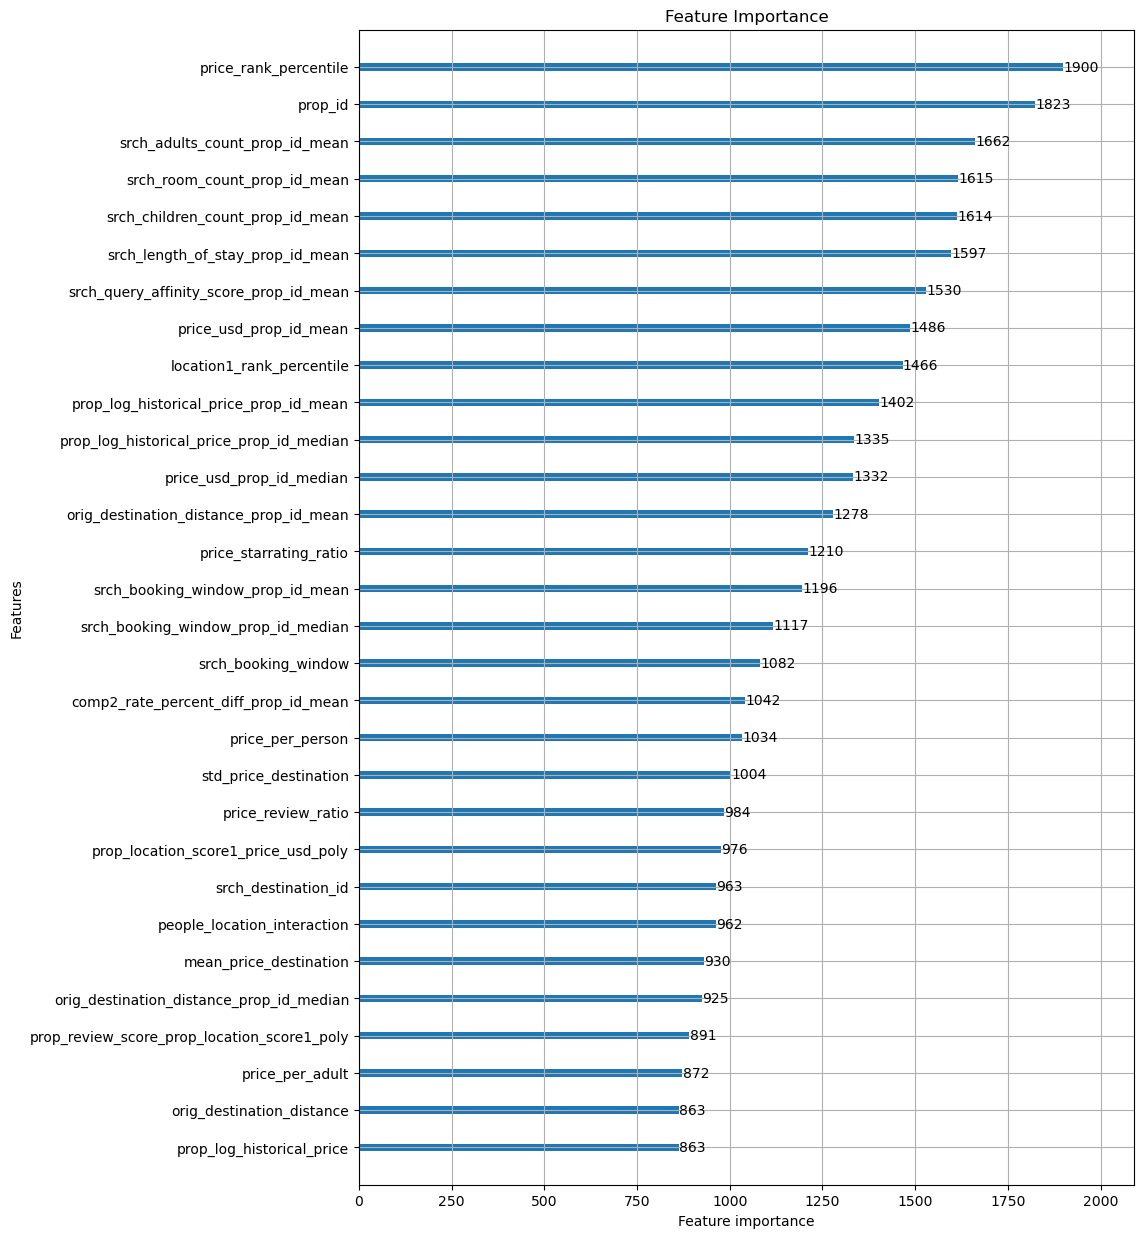

/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_73153/171187784.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predictions'] = test_pred
/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_73153/171187784.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.sort_values(['srch_id', 'predictions'], ascending=[True, False], inplace=True)


Average NDCG Score: 0.408326105154615


In [48]:
unique_ids = df['srch_id'].unique()
train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42, shuffle=True)
train_df = df[df['srch_id'].isin(train_ids)]
test_df = df[df['srch_id'].isin(test_ids)]


# 准备 LightGBM 数据结构
train_data = lgb.Dataset(train_df[features], label=train_df['score'], group=train_df['srch_id'].value_counts().sort_index())
test_data = lgb.Dataset(test_df[features], label=test_df['score'], group=test_df['srch_id'].value_counts().sort_index())

# 设置模型参数
params = {'num_leaves': 136, 'max_depth': 14, 'min_child_samples': 215, 'learning_rate': 0.1, 'feature_fraction': 0.77, 'bagging_fraction': 0.9, 'bagging_freq': 4, 'reg_alpha': 19, 'reg_lambda': 100, 'num_iterations': 400, 'objective': 'lambdarank', 'metric': 'ndcg', 'ndcg_eval_at': [5], 'verbose': -1, 'boosting_type': 'gbdt', 'feature_pre_filter': False}
# 训练模型
num_round = 300
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])

lgb.plot_importance(bst, max_num_features=30, importance_type='split', figsize=(10, 15), title='Feature Importance')
plt.show()
# 预测测试集
test_pred = bst.predict(test_df[features])

# 评估模型，计算 NDCG 分数
test_df['predictions'] = test_pred

# 首先确保数据按照 srch_id 和 predictions 降序排序
test_df.sort_values(['srch_id', 'predictions'], ascending=[True, False], inplace=True)

# 分组并计算每个搜索会话的 NDCG
grouped = test_df.groupby('srch_id')
ndcg_scores = []

for name, group in grouped:
    group = group.sort_values('predictions', ascending=False)
    true_relevance = group['score'].values
    scores_pred = group['predictions'].values
    # 计算当前搜索会话的 NDCG 分数，并追加到列表中
    if len(np.unique(true_relevance)) > 1:  # 只计算有正样本的会话
        ndcg_scores.append(ndcg_score([true_relevance], [scores_pred], k=5))

average_ndcg = np.mean(ndcg_scores)
print(f"Average NDCG Score: {average_ndcg}")

In [45]:
importance = bst.feature_importance(importance_type='split')
feature_names = bst.feature_name()
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})

# 按重要性排序
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 保存到CSV文件
feature_importance_df.to_csv('feature_importance.csv', index=False)

print(feature_importance_df)

                             Feature  Importance
67             price_rank_percentile        1901
5                            prop_id        1769
43  srch_children_count_prop_id_mean        1672
41    srch_adults_count_prop_id_mean        1621
45      srch_room_count_prop_id_mean        1603
..                               ...         ...
98  prop_log_historical_price^2_poly           3
46    srch_room_count_prop_id_median           0
72                 total_competitors           0
25                         comp1_inv           0
32                 bool_visitor_hist           0

[101 rows x 2 columns]


In [46]:
chunk_size = 10000
chunks = np.array_split(df_test, len(df_test) // chunk_size + (len(df_test) % chunk_size > 0))
predictions = []  # 创建一个空列表以存储每个块的预测结果
for chunk in chunks:
    # 可以在这里添加数据预处理步骤，比如填充缺失值等
    chunk_pred = bst.predict(chunk[features])  # 应用模型进行预测
    chunk['predictions'] = chunk_pred  # 将预测结果添加到 DataFrame
    predictions.append(chunk[['srch_id', 'prop_id', 'predictions']])  # 仅保留需要的列

# 合并所有批次的预测结果
final_predictions = pd.concat(predictions).reset_index(drop=True)

print(final_predictions)

/Users/eva/opt/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


         srch_id  prop_id  predictions
0              1     3180    -0.157502
1              1     5543     0.564848
2              1    14142    -0.535759
3              1    22393    -0.169619
4              1    24194     0.529834
...          ...      ...          ...
4959178   332787    32019    -0.512868
4959179   332787    33959     0.616892
4959180   332787    35240    -1.873932
4959181   332787    94437    -0.348251
4959182   332787    99509    -0.295292

[4959183 rows x 3 columns]


In [47]:
# 确保按照预测分数排序，如果 Kaggle 要求
final_predictions.sort_values(['srch_id', 'predictions'], ascending=[True, False], inplace=True)

# 选择需要的列
final_predictions = final_predictions[['srch_id', 'prop_id']]

# 保存为 CSV 文件，确保不包含索引，包含列标题
final_predictions.to_csv('train=poly_features0.40927).csv', index=False, header=True)